In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
import time
import copy
import albumentations as A
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR


In [3]:
def plot_side_by_side(img_1, img_2, title1="Original Image", title2="Processed Image"):
    """
    A function to plot two images side by side.
    """
    if len(img_1.shape) == 3 or len(img_2.shape) == 3:
        img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
        img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(img_1, cmap='gray')
    axs[1].imshow(img_2, cmap='gray')

    axs[0].set_title(title1)
    axs[1].set_title(title2)

# Stolen from the lab notebooks

In [4]:
data_path = "./drive/MyDrive/scanner_A"

In [5]:


def resize_image(image, size=(512, 512)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

def load_patient_data(data_path):
    patient_images = []
    patient_labels = []
    patient_folders = [os.path.join(data_path, folder) for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]

    for patient_folder in tqdm(patient_folders):
        images, labels = [], []
        for file in tqdm(os.listdir(patient_folder)):
            if file.endswith('.bmp'):
                image_path = os.path.join(patient_folder, file)
                label_path = image_path.replace('.bmp', '.jpg')

                image = cv2.imread(image_path)
                label = cv2.imread(label_path)

                image = resize_image(image)
                label = resize_image(label)

                difference = cv2.absdiff(image, label)

                images.append(image)
                labels.append(difference)

        patient_images.append(images)
        patient_labels.append(labels)

    return patient_images, patient_labels

patient_images, patient_labels = load_patient_data(data_path)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

5 7
5 7


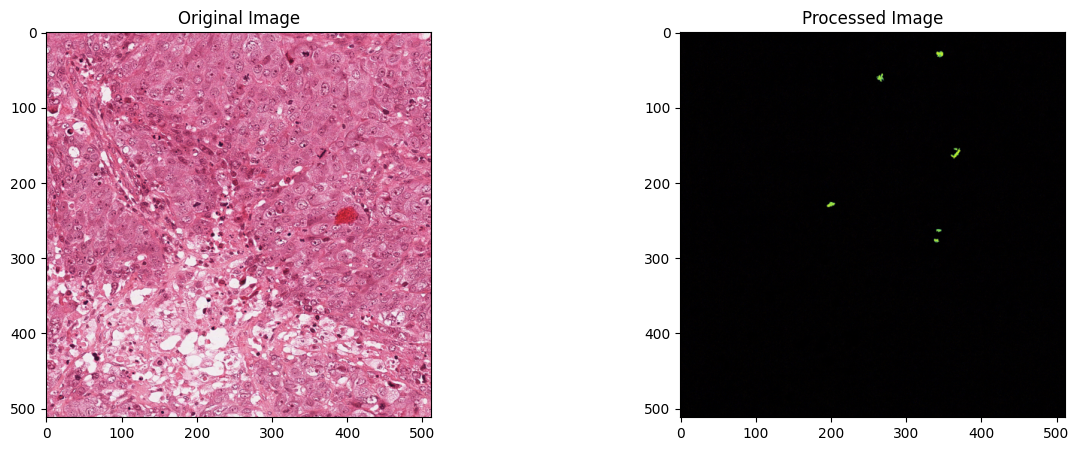

In [6]:
print(len(patient_images), len(patient_images[0]))
print(len(patient_labels), len(patient_labels[0]))
plot_side_by_side(patient_images[0][0], patient_labels[0][0])

In [7]:


def DiceLoss(inputs, targets, smooth=0):
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return 1 - dice

In [8]:

class UNet(nn.Module):
    def __init__(self, n_class):
        super(UNet, self).__init__()

        in_channels = 3
        out_channels = n_class

        self.encoder1 = self.double_conv(in_channels, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = self.double_conv(32, 64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder3 = self.double_conv(64, 128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self.double_conv(128, 256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = self.double_conv(256, 128)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = self.double_conv(128, 64)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = self.double_conv(64, 32)

        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

    def forward(self, x):
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)

        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)

        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)

        b = self.bottleneck(p3)

        u3 = self.upconv3(b)
        u3 = torch.cat([u3, e3], dim=1)
        d3 = self.decoder3(u3)

        u2 = self.upconv2(d3)
        u2 = torch.cat([u2, e2], dim=1)
        d2 = self.decoder2(u2)

        u1 = self.upconv1(d2)
        u1 = torch.cat([u1, e1], dim=1)
        d1 = self.decoder1(u1)

        out = self.out_conv(d1)
        return out

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device}")
else:
    print("GPU not available. Using CPU instead.")

Using device: cuda


In [10]:


class CustomDataset(Dataset):
    def __init__(self, images, masks, transform=None, augment_factor=1):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.augment_factor = augment_factor

    def __len__(self):
        return len(self.images) * self.augment_factor

    def __getitem__(self, idx):
        original_idx = idx % len(self.images)
        image = self.images[original_idx]
        mask = self.masks[original_idx]

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        if not isinstance(image, torch.Tensor):
            if image.max() > 1.0:
                image = image / 255.0
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        if not isinstance(mask, torch.Tensor):
            if mask.ndim == 3 and mask.shape[2] == 3:
                mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
            mask = (mask > 127).astype(np.float32)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

transform = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15),
    A.GaussNoise(),
    A.RandomBrightnessContrast(),
    A.HueSaturationValue(),
], additional_targets={'mask': 'mask'})

In [11]:
def calculate_metrics(preds, targets):
    preds = (preds > 0.5).float().cpu().numpy()
    targets = targets.cpu().numpy()

    precision = precision_score(targets.flatten(), preds.flatten(), zero_division=0)
    recall = recall_score(targets.flatten(), preds.flatten(), zero_division=0)
    f1 = f1_score(targets.flatten(), preds.flatten(), zero_division=0)

    return precision, recall, f1

In [12]:
def get_sample(dataset, index):
    image, mask = dataset[index]

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze(0).numpy()

    return image, mask

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

In [ ]:


kf = KFold(n_splits=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

precision_list = []
recall_list = []
f1_list = []
fold = 1
for train_index, test_index in kf.split(patient_images):
    print("\n\n===========================================================")
    print("Fold:", fold, "\n")
    fold += 1
    train_images = [img for i in train_index for img in patient_images[i]]
    train_masks = [msk for i in train_index for msk in patient_labels[i]]
    test_images = [img for i in test_index for img in patient_images[i]]
    test_masks = [msk for i in test_index for msk in patient_labels[i]]

    train_dataset = CustomDataset(images=train_images, masks=train_masks, transform=None, augment_factor=1)

    test_dataset = CustomDataset(images=test_images, masks=test_masks, transform=None, augment_factor=1)


    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

    model = UNet(n_class=1)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

    for epoch in range(200):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = FocalLoss()(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            all_preds.append(preds)
            all_targets.append(masks)

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    precision, recall, f1 = calculate_metrics(all_preds, all_targets)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)
mean_f1 = np.mean(f1_list)
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Recall: {mean_recall:.4f}')
print(f'Mean F1-Score: {mean_f1:.4f}')

# Save the trained model
torch.save(model.state_dict(), "./unet_model.pth")



Fold: 1 



/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss: 0.0399
Epoch 2, Loss: 0.0349
Epoch 3, Loss: 0.0313
Epoch 4, Loss: 0.0277
Epoch 5, Loss: 0.0242
Epoch 6, Loss: 0.0210
Epoch 7, Loss: 0.0180
Epoch 8, Loss: 0.0155
Epoch 9, Loss: 0.0136
Epoch 10, Loss: 0.0122
Epoch 11, Loss: 0.0110
Epoch 12, Loss: 0.0102
Epoch 13, Loss: 0.0094
Epoch 14, Loss: 0.0086
Epoch 15, Loss: 0.0082
Epoch 16, Loss: 0.0077
Epoch 17, Loss: 0.0073
Epoch 18, Loss: 0.0068
Epoch 19, Loss: 0.0064
Epoch 20, Loss: 0.0061
Epoch 21, Loss: 0.0057
Epoch 22, Loss: 0.0054
Epoch 23, Loss: 0.0051
Epoch 24, Loss: 0.0049
Epoch 25, Loss: 0.0055
Epoch 26, Loss: 0.0047
Epoch 27, Loss: 0.0048
Epoch 28, Loss: 0.0047
Epoch 29, Loss: 0.0045
Epoch 30, Loss: 0.0043
Epoch 31, Loss: 0.0041
Epoch 32, Loss: 0.0040
Epoch 33, Loss: 0.0038
Epoch 34, Loss: 0.0036
Epoch 35, Loss: 0.0035
Epoch 36, Loss: 0.0033
Epoch 37, Loss: 0.0032
Epoch 38, Loss: 0.0031
Epoch 39, Loss: 0.0030
Epoch 40, Loss: 0.0029
Epoch 41, Loss: 0.0028
Epoch 42, Loss: 0.0027
Epoch 43, Loss: 0.0027
Epoch 44, Loss: 0.00

In [ ]:
print(precision_list)
print(recall_list)
print(f1_list)